## Estimating the period of a signal

Allen Downey

[MIT License](https://opensource.org/licenses/MIT)

A Reddit user recently posted [this question](https://www.reddit.com/r/statistics/comments/csxq35/q_analysis_of_data_set_approximate_sine_wave/)

>I have temperatures reading over times (2 secs interval) in a computer that is control by an automatic fan. The temperature fluctuate between 55 to 65 in approximately sine wave fashion. I wish to find out the average time between each cycle of the wave (time between 55 to 65 then 55 again the average over the entire data sets which includes many of those cycles) . What sort of statistical analysis do I use?

>[The following] is one of my data set represents one of the system configuration. Temperature reading are taken every 2 seconds. Please show me how you guys do it and which software. I would hope for something low tech like libreoffice or excel. Hopefully nothing too fancy is needed.

A few people recommended using FFT, and I agreed, but I also suggested two other options:

1) Use a [cepstrum](https://en.wikipedia.org/wiki/Cepstrum), or

2) Keep it simple and use [zero-crossings](https://en.wikipedia.org/wiki/Zero_crossing)  instead.

And then another person suggested autocorrelation.  So, let's see what each of these solutions looks like and what works best.

If you are too busy to read the whole thing, I think the best option is computing the distance between zero crossings using a spline fitted to the smoothed data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### The signal

Here's the data provided by OP:

In [2]:
s = "55 56 56 56 56 57 57 57 56 57 59 57 59 58 59 59 59 59 59 59 59 60 61 60 60 61 61 61 62 62 62 62 61 61 61 61 62 62 63 63 62 63 62 63 63 63 64 63 63 63 63 62 62 61 60 58 59 58 58 57 58 57 56 56 56 56 56 55 55 55 55 54 54 55 56 56 56 57 56 57 57 57 58 57 58 59 57 59 59 59 58 60 59 60 60 59 60 61 60 60 61 61 61 61 61 61 61 62 62 63 62 63 63 63 63 62 63 63 63 63 63 63 63 64 63 63 63 63 62 61 60 60 58 59 59 58 58 58 57 56 56 56 55 55 56 55 55 54 55 55 54 55 55 55 56 56 56 57 57 57 57 57 58 57 60 58 58 59 58 60 60 60 60 60 60 61 61 61 62 61 62 61 62 62 62 62 62 62 61 62 64 63 62 62 63 63 63 63 64 63 62 63 64 64 63 64 64 63 65 63 64 62 62 60 60 59 59 57 57 57 56 55 55 55 55 55 54 55 54 54 54 54 55 55 57 56 57 56 56 58 58 59 58 58 58 58 58 58 59 59 60 60 60 60 60 61 60 61 61 60 61 62 61 62 62 61 62 61 62 62 62 61 62 63 63 63 63 64 63 63 63 63 64 63 64 64 63 62 61 60 61 59 60 58 57 57 56 56 57 55 56 55 55 55 55 55 55 56 56 56 56 56 57 57 58 58 59 59 58 59 60 60 60 59 60 59 60 60 60 60 61 62 61 61 62 61 61 62 62 63 61 62 63 63 62 63 64 63 63 63 62 61 61 60 60 60 58 58 57 57 57 56 57 56 56 56 55 56 56 57 58 57 58 57 57 59 59 58 59 59 60 59 60 59 60 59 61 61 60 61 61 61 61 62 61 62 62 62 62 62 62 63 62 63 61 63 63 62 63 63 64 63 64 64 65 63 65 63 65 63 63 63 61 60 59 60 59 58 57 57 56 56 56 55 55 55 56 56 56 56 58 57 57 58 58 57 58 58 60 59 59 60 60 61 61 60 61 60 61 61 61 61 61 62 62 62 62 63 62 62 63 62 62 61 63 63 64 64 64 63 64 63 64 64 64 62 62 61 61 60 59 59 58 58 58 56 56 56 56 55 56 55 55 54 55 55 56 55 57 57 58 58 58 57 59 58 58 58 58 59 59 61 60 59 60 60 60 59 60 60 60 61 62 61 61 62 62 62 63 62 62 62 62 63 63 63 63 62 63 63 64 63 64 64 64 64 63 64 63 63 65 64 63 63 63 62 63 60 61 60 60 59 59 57 58 58 58 56 56 56 55 55 55 55 55 56 56 55 55 56 57 57 58 57 58 59 58 58 59 60 59 59 60 60 61 60 60 61 60 60 61 61 62 60 61 61 62 63 62 62 62 62 63 62 63 63 64 63 64 64 63 63 63 63 63 64 64 64 63 64 63 63 61 60 60 59 58 58 58 58 57 56 56 55 56 55 55 55 55 55 55 55 55 55 55 56 55 56 58 57 58 58 59 57 57 58 59 58 59 59 59 60 60 60 61 61 60 60 61 62 61 61 61 62 61 62 62 62 62 63 62 63 63 62 63 63 62 62 64 64 64 64 64 65 63 65 64 63 62 61 61 60 60 59 58 58 58 57 57 56 55 56 56 55 54 55 55 54 55 56 57 55 56 57 58 57 57 58 59 57 58 58 59 59 60 60 60 60 60 60 60 61 61 61 61 61 61 60 62 62 62 62 62 63 62 62 63 62 63 63 63 63 63 63 63 64 64 63 63 64 64 64 63 64 64 63 62 61 61 60 59 59 59 59 58 58 58 57 57 57 56 56 56 55 55 54 55 54 55 54 55 56 56 55 57 56 57 57 57 57 58 59 58 58 59 58 59 59 59 59 61 60 60 61 61 60 60 60 60 60 61 63 61 62 63 63 62 63 62 62 62 62 63 63 63 62 64 63 64 63 64 63 64 64 62 62 60 59 60 59 58 57 57 57 57 56 55 56 56 55 55 55 55 55 55 55 55 56 55 57 57 56 58 57 58 58 59 59 60 59 58 60 60 60 60 59 60 60 60 60 60 61 61 61 61 61 61 62 61 62 63 63 62 61 62 63 63 63 63 63 64 64 64 64 63 64 63 63 64 63 64 64 64 63 64 61 60 61 61 59 59 59 59 58 57 57 57 57 55 57 56 55 55 55"
t = s.split()
len(t)

974

I'll put it in an array and plot it:

In [3]:
ys = np.array(t, dtype=float)
ts = np.arange(0, len(ys)) * 2

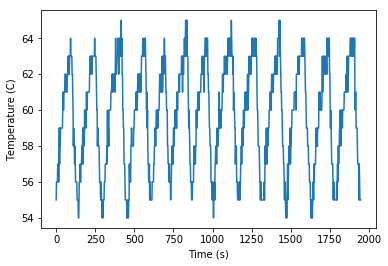

In [4]:
plt.plot(ts, ys)
plt.xlabel('Time (s)')
plt.ylabel('Temperature (C)');

Looks like a sawtooth.  I guess the computer heats up linearly and the cools off quickly when the fan comes on.

And it definitely looks periodic, although we should not assume that the period is constant.  The computer might generate more heat under some conditions and heat up more quickly.

### FFT

Let's see if we can estimate the frequency.  I'll center and the compute the (real) FFT.

In [5]:
centered = ys - np.mean(ys)

In [6]:
fft = np.fft.rfft(centered)

Here are the frequencies in Hz.

In [7]:
freq = np.fft.rfftfreq(len(centered), d=2)

I'll plot the magnitude of the FFT versus frequency.

In [8]:
mag = np.absolute(fft)

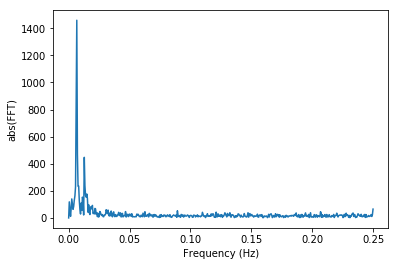

In [9]:
plt.plot(freq, mag)
plt.xlabel('Frequency (Hz)')
plt.ylabel('abs(FFT)');

Looks like there's a nice peak at the fundamental frequency, and one visible harmonic.  Since the wave resembles a sawtooth, I expected to see more harmonics.

Anyway, we can find the index of the peak, the corresponding frequency, and the corresponding period.

In [10]:
index = np.argmax(mag)
index

13

In [11]:
freq[index]

0.006673511293634497

In [12]:
period = 1 / freq[index]
period

149.84615384615384

Looks like the period is about 150 seconds.

### Cepstrum

A cepstrum can be a good way to estimate the fundamental frequency of a signal with strong harmonics.  But this signal doesn't have a lot of harmonics, so I don't expect it to work well.

Nevertheless, the idea is to treat the FFT as if it were a signal, and compute the IFTT of the squared magnitudes.

In [13]:
fft = np.fft.fft(centered)
log_mag = np.log(mag**2)
log_mag -= np.mean(log_mag)
cepstrum = np.absolute(np.fft.ifft(log_mag))

Here's what it looks like:

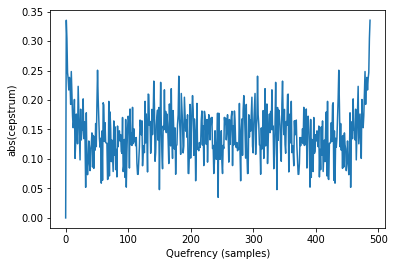

In [14]:
plt.plot(cepstrum)
plt.xlabel('Quefrency (samples)')
plt.ylabel('abs(cepstrum)');

Not much help there.  I withdraw my suggestion.

### Zero crossings

Because the signal has such clear periodic behavior, we can estimate the period just by counting zero crossings or measuring the distance between them.

But with a noisy signal, we should smooth it first to make sure we don't get spurious crossings.

I'll compute a moving average with a window width of 11.

In [15]:
n = 11
w = np.ones(n)
w /= sum(w)

smooth = np.convolve(w, centered, mode='valid')
ts = np.arange(0, len(smooth)) * 2

Here's the smoothed signal.

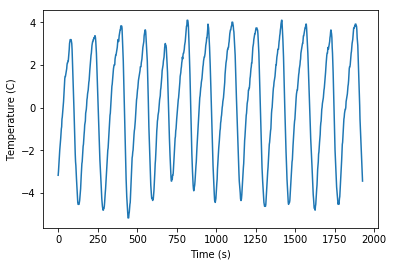

In [16]:
plt.plot(ts, smooth)
plt.xlabel('Time (s)')
plt.ylabel('Temperature (C)');

The fancy way to count zero-crossings is to interpolate and compute roots.

In [17]:
from scipy.interpolate import InterpolatedUnivariateSpline
interp = InterpolatedUnivariateSpline(ts, smooth)
zeros = interp.roots()

Now we can compute the average distance between zeros and double it to get the period.

In [18]:
diffs = np.diff(zeros)
diffs.mean() * 2

150.19431794935966

Yup, looks like 150.

One nice thing about this method is that we can use the variability in `diffs` to quantify the precision of the estimate.

In [19]:
standard_error_of_the_mean = np.std(diffs) / np.sqrt(len(diffs))
standard_error_of_the_mean

1.957380324695285

A [simpler way to count zero crossings](https://stackoverflow.com/questions/30272538/python-code-for-counting-number-of-zero-crossings-in-an-array) is to look for adjacent elements with opposite sign.

In [20]:
crossings = ((smooth[:-1] * smooth[1:]) < 0).sum()
crossings

26

And divide the duration by the number of crossings.

In [21]:
duration = len(smooth) * 2
duration

1928

Looks like the period is about 150 s.

In [22]:
period = duration / crossings * 2
period

148.30769230769232

The simple method might be less accurate with another dataset, since there's no guarantee we have an integer number of periods in the observation window.

### Autocorrelation

Another reddit user suggests:

>Autocorrelation. Note that we get multiply peaks for different "harmonics", acutally this analysis shows that the second harmonic has a higher correlation than the "fundamental", you could not see this easily from only peak-to-peak analysis.

They provided the following code to demonstrate:

Autocorrelation: 84
Mean peak difference: 81.27272727272727


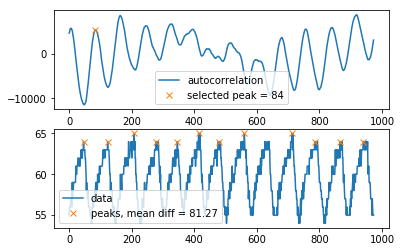

In [23]:
import numpy as np
from scipy.signal import detrend

x = ys

c = np.correlate(x,x,mode='full')
c = detrend(c[c.shape[0]//2:])
cpeak = c[50:130].argmax()+50
print('Autocorrelation:',cpeak)

peaks = np.array([x[n*80:n*80+80].argmax()+n*80
                  for n in range(x.shape[0]//80)])
mpeaks = np.mean(peaks[1:] - peaks[:-1])
print('Mean peak difference:',mpeaks)

from matplotlib import pyplot as plt
plt.subplot(211)
plt.plot(c, label='autocorrelation')
plt.plot(cpeak, c[cpeak], 'x', label='selected peak = %d'%cpeak)
plt.legend()
plt.subplot(212)
plt.plot(x, label='data')
plt.plot(peaks, x[peaks], 'x', label='peaks, mean diff = %0.02f'%mpeaks)
plt.legend()
plt.show()

The selected lag in the ACF is 84 samples, which corresponds to a period of 168 seconds, a little higher than my estimates.

And the average distance they compute between peaks is 81 samples, or 162 seconds, also a little higher than mine.

I'm not surprised that the peak of the ACF is a little off, due to limited resolution, but I thought the distances between the peaks would be more accurate.

### Summary

In my opinion, computing the distance between zero crossings, using a spline fitted to the smoothed data, is the best option.